In [1]:
import sys

sys.path.append("lib/")

import os
import glob
import json
import jsonpickle

import TFilter as f
import TEventFilter as ef
from TDataType import TDataType as tdt
from TMap import TMap
from TPlotter import TPlotter
from TReader import TReader

In [2]:
# load data
filepaths = glob.glob(os.path.join("../../../DP/filtered/", "*.csv"))
zones_file = "data/zones.json"

LIMIT = 0  # number or 0 for no limit

reader = TReader(filepaths)

# Load TDFs
ltdfs = reader.read(LIMIT)

len(ltdfs)

1440

In [3]:
# settings
T_Line = ("*", "*", "*")
T_Date = ("01.10.2022", "31.10.2022")
T_Time = ("00:00:00", "23:59:59")
T_Vehicle = "*"

T_Data_type = tdt.EMB_2

T_Map_events = True
T_Events_stop = True
T_Events_zero = True
T_Events_diff = 20

# depos zones
with open(zones_file, "r") as file:
    filter_zones = json.load(file)


# filter all ltdfs and data
data = f.filter_tdfs(ltdfs, T_Line, T_Date, T_Vehicle)
for d in data:
    d.filter_rows(T_Data_type, T_Time)
    d.filter_zones(filter_zones)
print(len(data))

# detect and filter events
events = ef.detect_events(data)
print(len(events))

if T_Events_diff:
    events = ef.filter_diff(events, T_Events_diff)
if T_Events_zero:
    events = ef.filter_zero(events)
if T_Events_stop:
    events = ef.filter_embs(events)

print(len(events))

1419
[(48.171892, 17.141307, Timestamp('2022-10-26 09:16:53.200000'), 15.6, '4131', 0.0, 1.0, 1.0, 1.0, 1.0, 1.0), (48.171892, 17.141307, Timestamp('2022-10-26 09:16:53.300000'), 12.7, '4131', 0.0, 1.0, 1.0, 1.0, 1.0, 1.0), (48.171892, 17.141307, Timestamp('2022-10-26 09:16:53.700000'), 8.5, '4131', 0.0, 1.0, 1.0, 1.0, 1.0, 1.0), (48.171892, 17.141307, Timestamp('2022-10-26 09:16:53.800000'), 8.5, '4131', 0.0, 1.0, 1.0, 1.0, 1.0, 1.0)]
902
6


In [4]:
m = TMap()

m.add_filter_zones(filter_zones)

# plot into map
if T_Map_events:
    m.add_events(events)
else:
    m.add_data(data)

m.save()
m.save_png()

print(m.n)
m.m

6


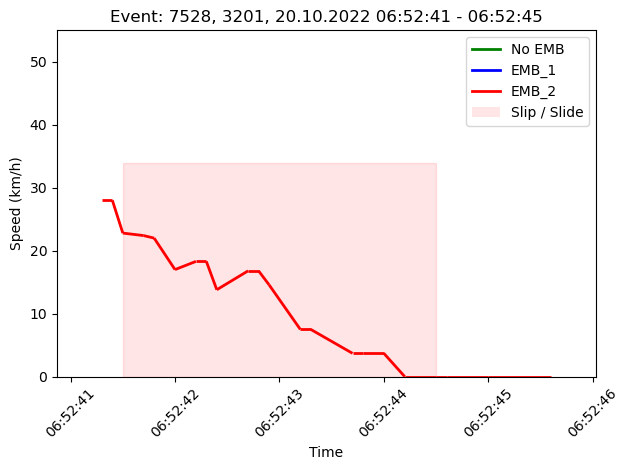

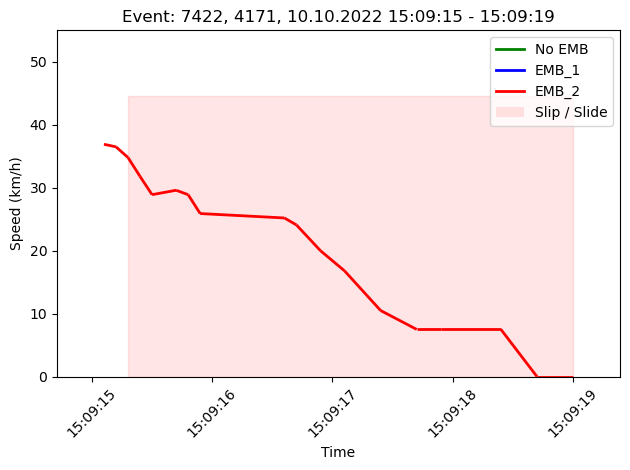

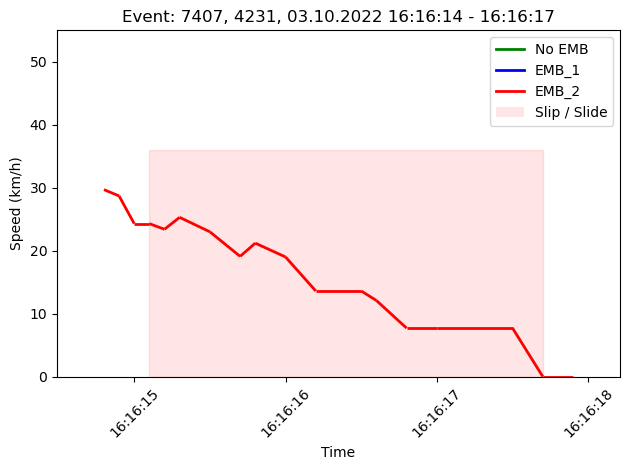

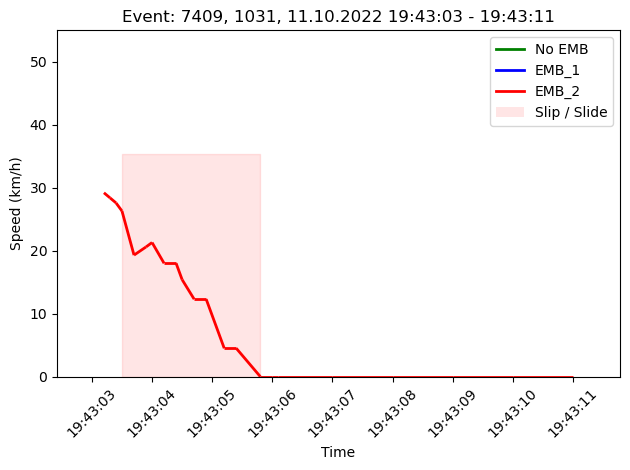

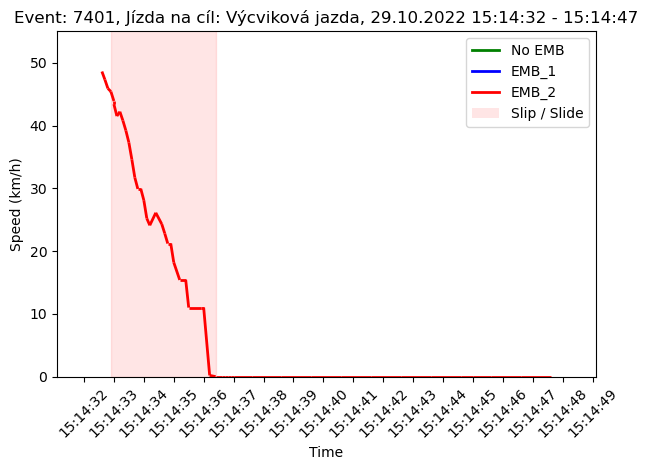

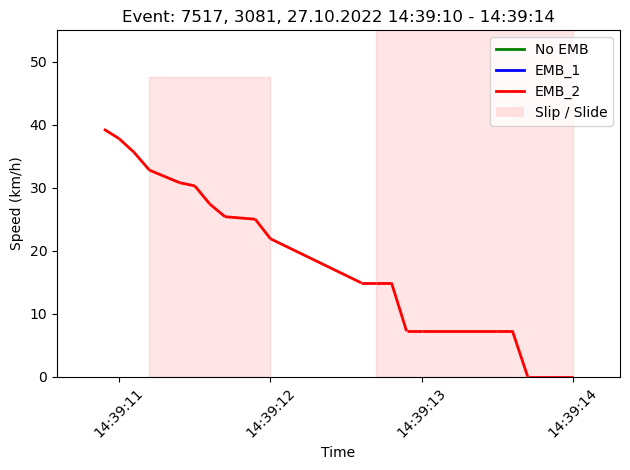

In [5]:
p = TPlotter()
p.plot_events(events)

In [6]:
# Serialize event objects
json_data = jsonpickle.encode(events, unpicklable=False, indent=4)

# Write JSON data to a file
with open("data/output.json", "w") as json_file:
    json_file.write(json_data)

In [7]:
# co dalej?
#
# asi by sa hodilo, aby sme vedeli odlisit tie miesta brzdenia, ktore su naozaj na tom mieste na ktorom sa stali, nie na doplnenom
# Folium plugin HeatMapWithTime ?
# skusit polohu brzdeni interpolovat a nie len doplnovat? - stale nevyriesi problem ze su tie brzdenia vsade
#

# zastavenia z malej rychlosti
# histogramy liniek/casu podla zvonenia
# rozbit to potom na dni a porovnat s pocasim + sklz/smyk

# do papiera - ako som spracoval data, co som mergoval, cela pipeline az po dataset s ktorym sa hram
# finalna struktura dat s ktorymi pracujeme
# briefly jupiter ako pseudokod?
#